In [71]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler


sales_doc = "../doccuments/sales_and_eodStocks.xlsx"
transactions_doc = "../doccuments/transactions.xlsx"

sales_df = pd.read_excel(sales_doc)
sales_df['Product_ID'] = sales_df['Product_ID'].astype(str)
transactions_sales_df = pd.read_excel(transactions_doc)
print(sales_df.head())
print(transactions_sales_df.head())

def scale_data(sales_df, columns, method='standardization'):
    """
    Scale the specified columns of the dataframe using the chosen method.

    Parameters:
    sales_df (pandas.DataFrame): The dataframe containing the data.
    columns (list): List of column names to be scaled.
    method (str): The scaling method - 'standardization' or 'normalization'.

    Returns:
    pandas.DataFrame: The dataframe with the specified columns scaled.
    """
    scaler = StandardScaler() if method == 'standardization' else MinMaxScaler()

    # Scale only the specified columns
    sales_df_scaled = sales_df.copy()
    sales_df_scaled[columns] = scaler.fit_transform(sales_df_scaled[columns])

    return sales_df_scaled
# sales_sales_df = scale_data(sales_sales_df,['Sales'])
print(sales_df.head())
print(transactions_sales_df.head())

  Product_ID       Date  Sales  Revenue  EndOfDayStock
0      10002 2009-12-01     12    10.20          48692
1      10002 2009-12-03      7     5.95          48685
2      10002 2009-12-04     73    62.05          48612
3      10002 2009-12-06     49    41.65          48563
4      10002 2009-12-07      2     1.70          48561
   Invoice Product_ID                          Description  Quantity  \
0   489434      85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434     79323P                   PINK CHERRY LIGHTS        12   
2   489434     79323W                  WHITE CHERRY LIGHTS        12   
3   489434      22041         RECORD FRAME 7" SINGLE SIZE         48   
4   489434      21232       STRAWBERRY CERAMIC TRINKET BOX        24   

                 Date  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95        13085  United Kingdom  
1 2009-12-01 07:45:00   6.75        13085  United Kingdom  
2 2009-12-01 07:45:00   6.75        13085  United Kingdom

NameError: name 'sales_sales_df' is not defined

22805.0 4686.0 8641.0
      Product_ID       Date  Sales  Revenue  EndOfDayStock  StockDiff  \
55637      21232 2009-12-02    164   177.64          25145     -164.0   
55638      21232 2009-12-03    216   256.32          24929     -216.0   
55639      21232 2009-12-04    264   302.64          24665     -264.0   
55640      21232 2009-12-05     36    45.00          24629      -36.0   
55641      21232 2009-12-06     54    67.50          24575      -54.0   
...          ...        ...    ...      ...            ...        ...   
55893      21232 2010-10-24     98   122.50           4097      -98.0   
55894      21232 2010-10-25     73    91.25           4024      -73.0   
55895      21232 2010-10-26    291   318.15           3733     -291.0   
55896      21232 2010-10-27     52    65.00           3681      -52.0   
55897      21232 2010-10-28     54    67.50           3627      -54.0   

               Anomaly  AnomalyDetection  
55637  Too Small Stock                -1  
55638  Too Smal

/Users/ioancristianlefter/miniforge3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


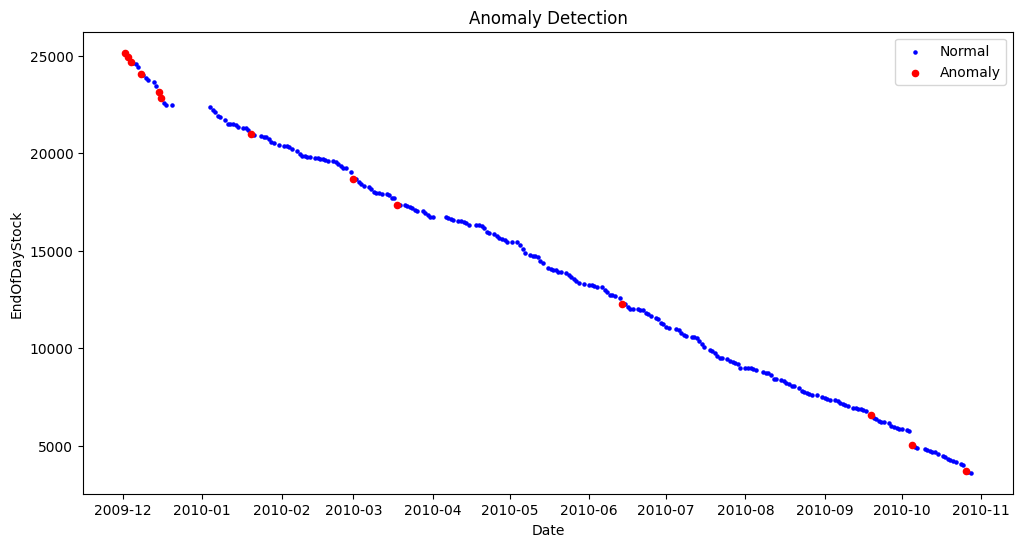

In [90]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Step 4: Labeling Anomalies
def label_anomalies(row, too_much_stock_threshold, too_small_stock_threshold, not_enough_stock_threshold):
    if row['StockDiff'] > too_much_stock_threshold:
        return 'Too Much Stock'
    elif row['StockDiff'] < too_small_stock_threshold:
        return 'Too Small Stock'
    elif row['EndOfDayStock'] < not_enough_stock_threshold:
        return 'Not Enough Stock'
    else:
        return 'Normal'

def detectAnomalies(product_id, start_date, end_date, data):

    product_data = data[(data['Product_ID'] == product_id) & (data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()

    product_data = product_data.sort_values(by=['Product_ID', 'Date'])

    # Step 2: Feature Engineering
    # Calculate StockDiff as the difference in stock levels between consecutive days within the same product
    product_data['StockDiff'] = product_data.groupby('Product_ID')['EndOfDayStock'].diff()
    product_data = product_data.dropna(subset=['Product_ID', 'StockDiff', 'EndOfDayStock'])

    # Adjusted quantile values for "Normal" classification
    too_much_stock_threshold = product_data['EndOfDayStock'].quantile(0.95)
    too_small_stock_threshold = product_data['EndOfDayStock'].quantile(0.05)
    not_enough_stock_threshold = product_data['EndOfDayStock'].quantile(0.25)
    print(too_much_stock_threshold, too_small_stock_threshold, not_enough_stock_threshold)

    # Step 3: Define Anomalies
    product_data['Anomaly'] = product_data.apply(lambda row: label_anomalies(row, too_much_stock_threshold, too_small_stock_threshold, not_enough_stock_threshold), axis=1)

    # Step 5: Machine Learning Model (Isolation Forest)
    X = product_data[['EndOfDayStock', 'StockDiff']]  # Remove 'Date' column

    model = IsolationForest(contamination=0.05)
    model.fit(X)

    # Step 6: Anomaly Detection
    product_data['AnomalyDetection'] = model.predict(X)
    # Step 7: Visualization
    anomalies = product_data[product_data['AnomalyDetection'] == -1]
    print(anomalies)
    return anomalies
    #print(anomalies)
# Implement alerting or actions based on detected anomalies.
detectAnomalies('21232',np.datetime64(pd.Timestamp('2009-10-28')),np.datetime64(pd.Timestamp('2010-10-28')),sales_df)